In [3]:
import util
import os
DATASET_FOLDER = "./data" 
TRAIN_FILES = f"{DATASET_FOLDER}/train_masked.txt"
TEST_FILES =  f"{DATASET_FOLDER}/test_masked.txt"

tr_files = open(TRAIN_FILES,"r").readlines()
tr_files = [os.path.join(DATASET_FOLDER,"data",f"{file.strip()}.jpg") for file in tr_files]

In [4]:
# recreate dataset for faster access
# import numpy as np 
# import glob
# import matplotlib.pyplot as plt
# from pathlib import Path
# mask_path = Path("./data/masks")
# mask_path.mkdir(parents=True,exist_ok=True)
# from PIL import Image
# for file_path in glob.glob(os.path.join(DATASET_FOLDER, "./data/")+"*.npz"):
#     mask = np.load(file_path)['arr_0']
#     file_name = file_path.split("/")[-1]
#     file_name = file_name.replace(".npz",".png")
#     mask = mask.max(axis=-1).astype('uint8')
#     img= Image.fromarray(mask)
#     img.save(mask_path.joinpath(file_name)) 
#     # print(, mask.max())
#     print(file_path)

In [5]:
from sklearn.model_selection import train_test_split
tr_files, val_files = train_test_split(tr_files,test_size=0.2,shuffle=True)
len(tr_files), len(val_files)

(88, 22)

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
tr_files[0]


'./data/data/CDY_2052.jpg'

In [8]:
import tensorflow as tf 
import util


def load_image_and_mask(file_path, mask_extension=".png"):
    mask_path = tf.strings.regex_replace(file_path,"a/data/","a/masks/")
    mask_path = tf.strings.regex_replace(mask_path,".jpg",mask_extension)
    # print(mask_path, file_path)
    image = tf.io.read_file(file_path)
    image = tf.io.decode_image(image)
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_image(mask)
    return image, mask

def preprocess_training(im,mask,crop_height=512,crop_width=512):
    im = tf.cast(im,tf.float32)/255.0 
    mask = tf.cast(mask,tf.float32)
    combined = tf.concat([im,mask],axis=-1)
    # return combined
    combined = tf.image.resize_with_pad(combined, target_height=crop_height*2, target_width=crop_height*2)
    combined = tf.image.random_crop(combined, [crop_height,crop_width, 4])
    # return combined[...,3:]
    combined = tf.image.random_flip_left_right(combined)
    combined = tf.image.random_flip_up_down(combined)
    combined = tf.image.rot90(combined)
    return combined[...,:3],tf.cast(combined[...,3:],tf.uint8)

def preprocess_validating(im,mask, height=1024, width=1024):
    im = tf.cast(im,tf.float32)/255.0 
    mask = tf.cast(mask,tf.float32)
    combined = tf.concat([im,mask],axis=-1)
    combined = tf.image.resize_with_pad(combined, height,width)
    return combined[...,:3],tf.cast(combined[...,3:],tf.uint8)


2024-11-02 13:57:48.844593: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 13:57:49.978492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


Training set 88


2024-11-02 13:57:50.513023: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


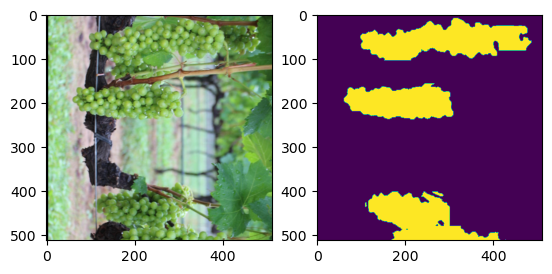

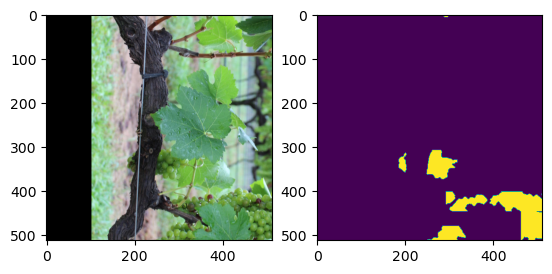

In [9]:
import matplotlib.pyplot as plt
train_ds = tf.data.Dataset.list_files(tr_files).map(load_image_and_mask).map(preprocess_training)

print("Training set",len(train_ds))
for image, mask in train_ds.take(2):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.show()
    

    

Validation set 22


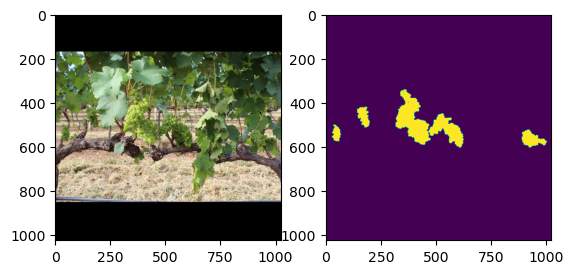

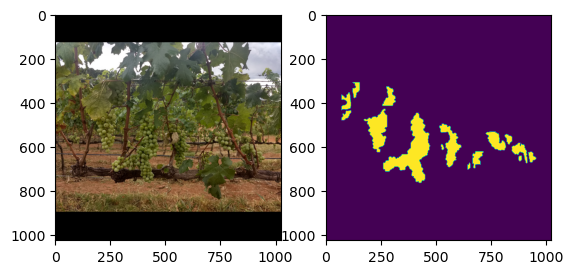

In [10]:
val_ds = tf.data.Dataset.list_files(val_files,shuffle=None).map(load_image_and_mask).map(preprocess_validating)

print("Validation set", len(val_ds))
import matplotlib.pyplot as plt
for image, mask in val_ds.take(2):
    # print(image.shape, mask.shape)
    # plt.show()
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.show()
    

In [11]:
import tensorflow as tf
import numpy as np

def upsample_block(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """
    # initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      # kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def downsample_block(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """
    # initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2,
                                      padding='same',
                                      # kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def get_mnet_encoder(input_shape=[None,None,3]):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    down_stack.trainable=False
    return down_stack


def get_unet_decoder():
    up_stack = [
        upsample_block(512, 3),  # 4x4 -> 8x8
        upsample_block(256, 3),  # 8x8 -> 16x16
        upsample_block(128, 3),  # 16x16 -> 32x32
        upsample_block(64, 3),   # 32x32 -> 64x64
    ]
    return up_stack 

def conv_block(filters):
    layers = tf.keras.Sequentialuential()
    layers.add(tf.keras.layers.Conv2D(filters, stride=1, padding="same",use_bias=False))
    layers.add(tf.keras.layers.BatchNormalization())
    layers.add(tf.keras.layers.ReLU())
    return layers

def unet_model(input_shape= [None,None,3], output_channels=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    encoder = get_mnet_encoder(input_shape=input_shape)
    decoder = get_unet_decoder()
    skips = encoder(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.Sequential()  #64x64 -> 128x128
    last.add(tf.keras.layers.Conv2DTranspose(
      filters=16,kernel_size=1,strides=2,
      padding='same'))
    last.add(tf.keras.layers.Conv2D(filters=output_channels, kernel_size=3, padding="same", use_bias=False))
    last.add(tf.keras.layers.BatchNormalization())
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

def iou_score(truth, prediction, epsilon=1e-6):
    truth = truth.numpy().flatten()
    prediction = prediction.numpy().flatten()
    intersection = np.multiply(truth, prediction).sum()
    union = np.clip(np.add(truth, prediction),0,1).sum() + epsilon
    
    return intersection/union

In [12]:
model = unet_model()
print(model(tf.ones([1,512,512,3])).shape)
model.summary()

2024-11-02 13:58:02.241946: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8902
2024-11-02 13:58:02.455650: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-02 13:58:02.456497: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-02 13:58:02.456513: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2024-11-02 13:58:02.456905: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-02 13:58:02.456948: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(1, 512, 512, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  1841984     input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 5 1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, None, 1 0           sequential[0][0]                 
                                                                 model[0][3

In [13]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]),tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]),tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def combined_bce_dice_loss(gamma=0.2):
    def loss(y_true, y_pred):
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
        y_ = tf.cast(tf.nn.sigmoid(y_pred) > 0.5,tf.uint8)
        dice = dice_loss(y_true, y_)
        return (1-gamma)*bce_loss + gamma*dice
    return loss

def dice_score(y_true, y_pred, smooth=1e-6):
    y_pred_f = tf.reshape(tf.cast(tf.nn.sigmoid(y_pred) > 0.5,tf.float32),[-1])
    y_true_f = tf.cast(tf.reshape(y_true, [-1]),tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# def i\\\

def iou_score(truth, prediction, epsilon=1e-6):
    y_pred_f = tf.reshape(tf.cast(tf.nn.sigmoid(prediction) > 0.5,tf.float32),[-1])
    y_true_f = tf.cast(tf.reshape(truth, [-1]),tf.float32)
    # truth = truth.numpy().flatten()
    
    # prediction = prediction.numpy().flatten()
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    union = tf.reduce_sum(tf.clip_by_value(tf.add(y_true_f, y_pred_f),clip_value_min=0,clip_value_max=1)) + epsilon
    
    return intersection/union

In [15]:
from pathlib import Path 
import pandas as pd
train_batched = train_ds.batch(8)
val_batched = val_ds.batch(8)
best_val = 9999
loss_fn = combined_bce_dice_loss(gamma=0.2)
learning_rates = [0.01, 0.001, 0.5]
loss_fns = {'0':combined_bce_dice_loss(gamma=0)}
patience=5
result_dir = "./results_benchmark/"
experiment_results = []
for gamma, loss_fn in loss_fns.items():
    for lr in learning_rates:
        prefix = str(lr).replace(".","") +"_"+ str(gamma).replace(".","")
        result_path = Path(result_dir+prefix)
        result_path.mkdir(parents=True, exist_ok=True)
        experiment = {}
        experiment['lr'] = str(lr)
        experiment['gamma'] = gamma 
        experiment['location'] = str(result_path.joinpath("best.hd5"))
        print(experiment)
        model = unet_model(input_shape=[None,None,3])
        model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Adam(learning_rate=lr),metrics=[iou_score, dice_score])
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss", restore_best_weights=True)
        history = model.fit(train_batched, validation_data=val_batched, epochs=60,callbacks=[early_stopping],verbose=1)
        experiment['training_loss'] = history.history['loss']
        experiment['validating_loss'] = history.history['val_loss']
        experiment['val_dice_score'] = history.history['val_dice_score']
        experiment['val_iou_score'] = history.history['val_iou_score']
        experiment['train_dice_score'] = history.history['dice_score']
        experiment['train_iou_score'] = history.history['iou_score']
        experiment['final_val_dice_score'] = experiment['val_dice_score'][(patience+1)*-1]
        print("Validation dice score",experiment['val_dice_score'][(patience+1)*-1])
        experiment_results.append(experiment)
        tf.keras.models.save_model(model,result_path.joinpath("best.hd5"))
        del model
pd.DataFrame(experiment_results).to_csv(result_dir+"result.csv",index=False)


{'lr': '0.01', 'gamma': '0', 'location': 'results_benchmark/001_0/best.hd5'}
Epoch 1/60
11/11 [==============================] - 31s 2s/step - loss: 0.6382 - iou_score: 0.3143 - dice_score: 0.4474 - val_loss: 205.5024 - val_iou_score: 0.0820 - val_dice_score: 0.1516
Epoch 2/60
11/11 [==============================] - 7s 589ms/step - loss: 0.4745 - iou_score: 0.6417 - dice_score: 0.7808 - val_loss: 45.8132 - val_iou_score: 0.0826 - val_dice_score: 0.1526
Epoch 3/60
11/11 [==============================] - 7s 592ms/step - loss: 0.4281 - iou_score: 0.6782 - dice_score: 0.8074 - val_loss: 11.8524 - val_iou_score: 0.0864 - val_dice_score: 0.1591
Epoch 4/60
11/11 [==============================] - 7s 593ms/step - loss: 0.3914 - iou_score: 0.7041 - dice_score: 0.8254 - val_loss: 4.9270 - val_iou_score: 0.1019 - val_dice_score: 0.1849
Epoch 5/60
11/11 [==============================] - 7s 596ms/step - loss: 0.3568 - iou_score: 0.7166 - dice_score: 0.8330 - val_loss: 2.5891 - val_iou_score: 0.1

2024-11-02 14:03:51.948908: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: results_benchmark/001_0/best.hd5/assets


/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.001', 'gamma': '0', 'location': 'results_benchmark/0001_0/best.hd5'}
Epoch 1/60
11/11 [==============================] - 9s 649ms/step - loss: 0.6571 - iou_score: 0.2535 - dice_score: 0.3925 - val_loss: 0.4730 - val_iou_score: 0.3679 - val_dice_score: 0.5369
Epoch 2/60
11/11 [==============================] - 7s 590ms/step - loss: 0.5308 - iou_score: 0.4845 - dice_score: 0.6495 - val_loss: 0.3647 - val_iou_score: 0.5196 - val_dice_score: 0.6836
Epoch 3/60
11/11 [==============================] - 6s 586ms/step - loss: 0.5033 - iou_score: 0.5966 - dice_score: 0.7459 - val_loss: 0.4331 - val_iou_score: 0.3953 - val_dice_score: 0.5665
Epoch 4/60
11/11 [==============================] - 7s 587ms/step - loss: 0.5098 - iou_score: 0.5923 - dice_score: 0.7400 - val_loss: 0.3704 - val_iou_score: 0.6125 - val_dice_score: 0.7596
Epoch 5/60
11/11 [==============================] - 6s 583ms/step - loss: 0.4923 - iou_score: 0.6385 - dice_score: 0.7762 - val_loss: 0.3589 - val_iou_score: 0.7

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


{'lr': '0.5', 'gamma': '0', 'location': 'results_benchmark/05_0/best.hd5'}
Epoch 1/60
11/11 [==============================] - 10s 650ms/step - loss: 0.4850 - iou_score: 0.0152 - dice_score: 0.0280 - val_loss: 72.2165 - val_iou_score: 0.0816 - val_dice_score: 0.1507
Epoch 2/60
11/11 [==============================] - 7s 594ms/step - loss: 0.3588 - iou_score: 0.0756 - dice_score: 0.1169 - val_loss: 195.5315 - val_iou_score: 0.0823 - val_dice_score: 0.1521
Epoch 3/60
11/11 [==============================] - 7s 589ms/step - loss: 0.1749 - iou_score: 0.6318 - dice_score: 0.7722 - val_loss: 119.4584 - val_iou_score: 0.0829 - val_dice_score: 0.1530
Epoch 4/60
11/11 [==============================] - 7s 591ms/step - loss: 0.1287 - iou_score: 0.6933 - dice_score: 0.8181 - val_loss: 63.4635 - val_iou_score: 0.0824 - val_dice_score: 0.1522
Epoch 5/60
11/11 [==============================] - 7s 589ms/step - loss: 0.1182 - iou_score: 0.7124 - dice_score: 0.8316 - val_loss: 20.9720 - val_iou_score:

/common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [16]:
df = pd.DataFrame(experiment_results)
df['epochs'] = df['train_dice_score'].map(lambda x: len(x))
df.to_csv("results.csv")

In [17]:
best_path = df[df['lr']== '0.001']['location']
# print(str(best_path))
best_model = tf.keras.models.load_model(str(best_path[1]), {'iou_score':iou_score,'dice_score':dice_score,'loss':combined_bce_dice_loss})

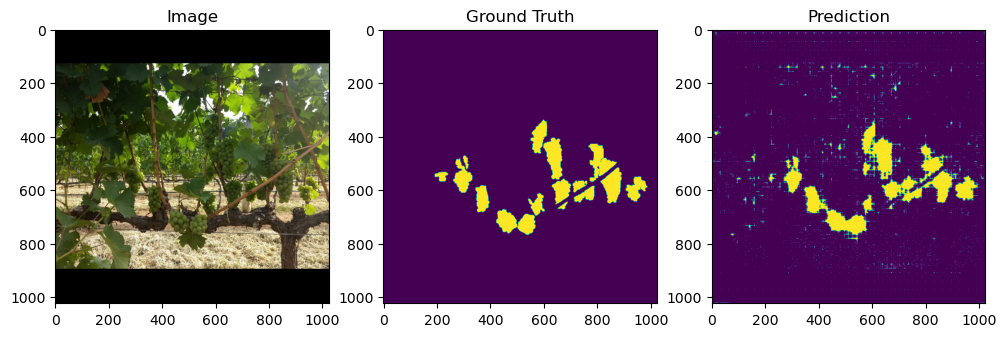

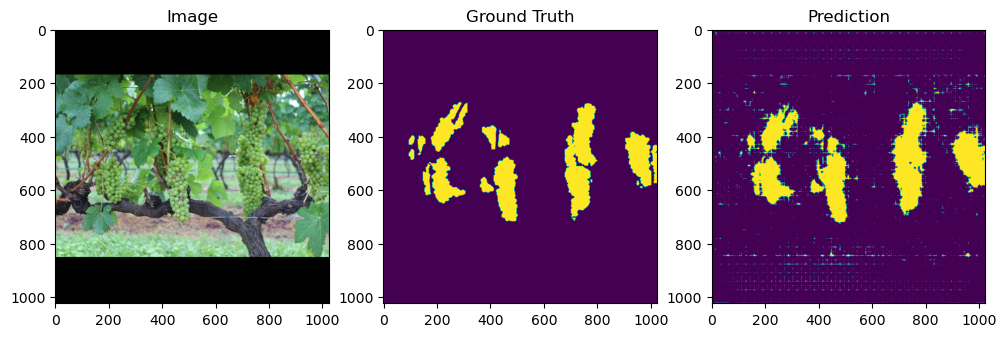

In [30]:
import matplotlib.pyplot as plt
c = 1
for image, mask in val_ds.take(2):
    fig,ax = plt.subplots(1,3, figsize=(12,12))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Ground Truth")
    # print(mask.numpy().max())
    prediction = tf.nn.sigmoid(best_model(image[None]))
    prediction = prediction[0]>0.5
    prediction = tf.cast(prediction, tf.float32)
    ax[2].imshow(prediction)
    ax[2].set_title("Prediction")
    plt.savefig(f"val_ds_prediction_result_{c}.png")
    c+=1
    plt.show()

In [22]:
from PIL import Image
eval_files = open(TEST_FILES,"r").readlines()
# print(eval_files[0], DATASET_FOLDER)
eval_files = [os.path.join(DATASET_FOLDER,"data",f"{file.strip()}.jpg") for file in eval_files]
# print(eval_files[0])
eval_ds = tf.data.Dataset.list_files(eval_files, shuffle=False).map(util.load_data).map(preprocess_validating)


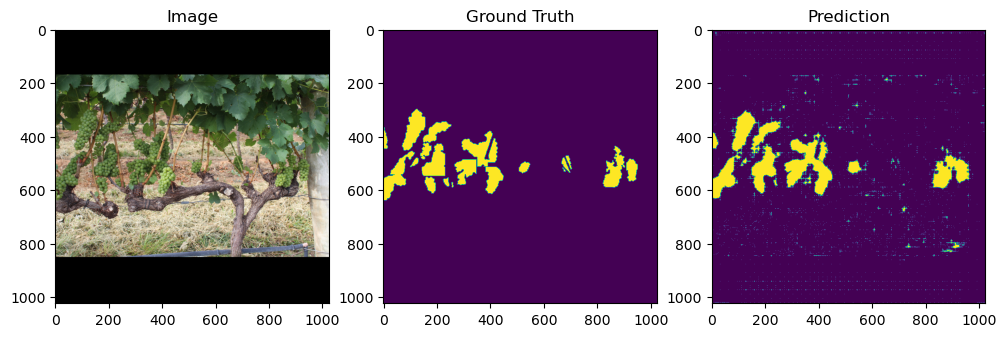

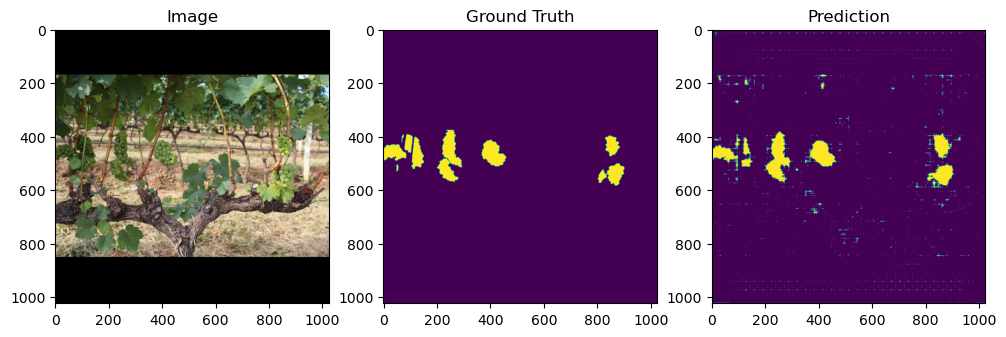

In [31]:
c = 1
for i, m in eval_ds.take(2):
    fig,ax = plt.subplots(1,3,figsize=(12,12))
    ax[0].imshow(i)
    ax[1].imshow(m)
    p = best_model(i[None])[0]
    p = tf.nn.sigmoid(p) > 0.5
    ax[2].imshow(p)
    ax[0].set_title("Image")
    ax[1].set_title("Ground Truth")
    ax[2].set_title("Prediction")
    plt.savefig(f"test_ds_prediction_result_{c}.png")
    c+=1
    plt.show()

In [62]:
predictions = best_model.predict(eval_ds.batch(1))


In [63]:
predictions.shape

(27, 1024, 1024, 1)

In [64]:
truth = tf.stack([m for _,m in  eval_ds],axis=0)
truth.shape

TensorShape([27, 1024, 1024, 1])

In [66]:
iou_score(truth, predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=0.75919485>

In [67]:
dice_score(truth, predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=0.86311626>

In [80]:
#Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
predictions_class = tf.reshape(tf.cast(tf.nn.sigmoid(predictions) > 0.5,tf.uint8),[-1])
ConfusionMatrixDisplay.from_predictions(
   tf.reshape(truth,[-1]), predictions_class, normalize="true")
plt.savefig("confusion_matrix.jpg")
plt.close()

In [1]:
import pandas as pd

results = pd.read_csv("results.csv")


In [2]:
results

,Unnamed: 0,lr,gamma,location,training_loss,validating_loss,val_dice_score,val_iou_score,train_dice_score,train_iou_score,final_val_dice_score,epochs
0,0,0.010,0,results_benchmark/001_0/best.hd5,"[0.6382432579994202, 0.47453442215919495, 0.42...","[205.5023956298828, 45.813167572021484, 11.852...","[0.15157847106456757, 0.1526213139295578, 0.15...","[0.08203460276126862, 0.08263907581567764, 0.0...","[0.4474372863769531, 0.7808366417884827, 0.807...","[0.31425487995147705, 0.6416930556297302, 0.67...",0.875915,44
1,1,0.001,0,results_benchmark/0001_0/best.hd5,"[0.6571407914161682, 0.5308183431625366, 0.503...","[0.4730236828327179, 0.3647288978099823, 0.433...","[0.5368742942810059, 0.6836197972297668, 0.566...","[0.36787328124046326, 0.5196197628974915, 0.39...","[0.3925255537033081, 0.6495038866996765, 0.745...","[0.2535393536090851, 0.4844975471496582, 0.596...",0.826381,10
2,2,0.500,0,results_benchmark/05_0/best.hd5,"[0.4849795401096344, 0.35880959033966064, 0.17...","[72.21647644042969, 195.5315399169922, 119.458...","[0.15073460340499878, 0.15209907293319702, 0.1...","[0.08157775551080704, 0.0823238417506218, 0.08...","[0.02800370380282402, 0.11691813915967941, 0.7...","[0.015185857191681862, 0.0756252110004425, 0.6...",0.866797,19


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
training_loss = results.iloc[0]['training_loss']
training_loss = [float(a) for a in training_loss[1:-1].split(",")]
validating_loss = results.iloc[0]['validating_loss']
validating_loss = [float(a) for a in validating_loss[1:-1].split(",")]
plt.plot(training_loss,label="training loss")
plt.plot(validating_loss, label="validating loss")
plt.ylim(0,2)
plt.xlabel("Epochs")
plt.legend()
plt.savefig("Training history.jpg")
plt.close()

[0.6382432579994202,
 0.47453442215919495,
 0.42810165882110596,
 0.3913624584674835,
 0.3567604422569275,
 0.318004310131073,
 0.2995936870574951,
 0.2724519968032837,
 0.2569969594478607,
 0.23882165551185608,
 0.22494393587112427,
 0.20520921051502228,
 0.1976367086172104,
 0.19121746718883514,
 0.18247590959072113,
 0.17291727662086487,
 0.1656070202589035,
 0.15583409368991852,
 0.14987900853157043,
 0.14920248091220856,
 0.14334087073802948,
 0.13839663565158844,
 0.13402050733566284,
 0.12927375733852386,
 0.12663401663303375,
 0.1294838935136795,
 0.1223604679107666,
 0.12071139365434647,
 0.11783599108457565,
 0.11260823905467987,
 0.1100132018327713,
 0.11343016475439072,
 0.1103682741522789,
 0.10727784037590027,
 0.10279946029186249,
 0.10387163609266281,
 0.09594187140464783,
 0.09884706139564514,
 0.0997527614235878,
 0.09605727344751358,
 0.09563010185956955,
 0.09682735800743103,
 0.09409711509943008,
 0.08980226516723633]